## SF Crime data analysis and modeling

In [2]:
from csv import reader
from pyspark.sql import Row 
from pyspark.sql import SparkSession
from pyspark.sql.types import ArrayType, IntegerType, BooleanType, StringType
from pyspark.sql.functions import to_date, year, month, dayofmonth, dayofweek, col, udf
from pyspark.sql.types import *
import matplotlib.colors as colors
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from ggplot import *
import warnings
import os
os.environ["PYSPARK_PYTHON"] = "python3"


In [3]:
crime_data_lines = sc.textFile('/FileStore/tables/sf_data2.csv')
#prepare data 
df_crimes = crime_data_lines.map(lambda line: [x.strip('"') for x in next(reader([line]))])
#get header
header = df_crimes.first()
#remove the first line of data
crimes = df_crimes.filter(lambda x: x != header)
#create pyspark sql dataframe
sf_crime = crimes.toDF(['IncidntNum', 'Category', 'Descript', 'DayOfWeek', 'Date', 'Time', 'PdDistrict', 'Resolution', 'Address', 'X', 'Y', 'Location', 'PdId'])
display(sf_crime)
sf_crime.createOrReplaceTempView("sf_crime")

In [4]:
date_to_interval = udf(lambda date: (int(date[:2])), IntegerType())
sf_data = sf_crime.withColumn('Hour', date_to_interval('Time'))
date_to_interval = udf(lambda date: (int(date[:2]), int(date[:2]) + 1), ArrayType(IntegerType()))
sf_data = sf_data.withColumn('timeInterval', date_to_interval('Time'))

sf_data = sf_data.withColumn('Date', to_date('Date', 'MM/dd/yyyy')). \
                  withColumn('year', year('Date')). \
                  withColumn('month', month('Date')). \
                  withColumn('dayOfMonth', dayofmonth('Date')). \
                  withColumn('dayOfWeek', dayofweek('Date'))
sf_data.createOrReplaceTempView("sf_data")
display(sf_data)

### Crimes count for diffferent category

In [6]:
count_by_category = spark.sql("SELECT category, COUNT(*) as Count FROM sf_data GROUP BY category ORDER BY count desc")
count_by_category_df = count_by_category.toPandas()
fig,axes = plt.subplots()
sb.barplot(y='category',x='Count',data=count_by_category_df,ax=axes)
plt.xlabel('Counts')
plt.xscale('log')
plt.title("The number of crimes for different category")
plt.tight_layout()
display(fig.show())

### Crimes count for diffferent district

In [8]:
count_by_district = spark.sql("SELECT pdDistrict, COUNT(*) as Count FROM sf_data GROUP BY pdDistrict ORDER BY count desc")
count_by_district_df = count_by_district.toPandas()
fig,axes = plt.subplots()
sb.barplot(y='pdDistrict',x='Count',data=count_by_district_df,ax=axes)
plt.xlabel('Counts')
plt.title("The number of crimes for different district")
plt.tight_layout()
display(fig.show())

### Crimes count by time

In [10]:
fig,(ax1,ax2,ax3,ax4,ax5) = plt.subplots(5,1,figsize=(10,10))
sb.set(style="whitegrid")
sb.countplot(x="Hour",data=sf_data.toPandas(),ax=ax1)
sb.countplot(x='dayOfWeek',data=sf_data.toPandas(),ax=ax2)
sb.countplot(x='dayOfMonth',data=sf_data.toPandas(),ax=ax3)
sb.countplot(x='month',data=sf_data.toPandas(),ax=ax4)
sb.countplot(x='year',data=sf_data.toPandas(),ax=ax5)
display(plt.show())

### Trend of crimes

In [13]:
sf_crime_by_month = sf_data.filter(year(sf_data.Date).between(2015, 2017)).groupBy(year(sf_data.Date), month(sf_data.Date)).count().orderBy(year(sf_data.Date), month(sf_data.Date))
display(sf_crime_by_month)

In [14]:
sf_crime_2015 = sf_crime_by_month.filter(sf_crime_by_month['year(Date)'] == 2015)
sf_crime_2016 = sf_crime_by_month.filter(sf_crime_by_month['year(Date)'] == 2016)
sf_crime_2017 = sf_crime_by_month.filter(sf_crime_by_month['year(Date)'] == 2017)
sf_crime_2015_df = sf_crime_2015.toPandas()
sf_crime_2016_df = sf_crime_2016.toPandas()
sf_crime_2017_df = sf_crime_2017.toPandas()

fig, (ax1,ax2,ax3) = plt.subplots(1,3)
sb.set(style="whitegrid")
sb.barplot(x="month(Date)", y="count",data=sf_crime_2015_df,ax=ax1)
ax1.set_title('2015')
sb.barplot(x="month(Date)", y="count",data=sf_crime_2016_df,ax=ax2)
ax2.set_title('2016')
sb.barplot(x="month(Date)", y="count",data=sf_crime_2017_df,ax=ax3)
ax3.set_title('2017')
plt.tight_layout()
display(fig.show())

### Analysis crime on a certain day in 3 years
Let's analysis crime on a certain day e.g. Dec 15th. and give travel suggestions

In [16]:
data_needed =  sf_data.filter(col('Date').isin('2015-12-15', '2016-12-15', '2017-12-15'))
display(data_needed)

In [17]:
def timePeriod(hour):
  if hour//6 == 0:
    return '00:00 ~ 05:59'
  elif hour//6==1:
    return '06:00 ~ 11:59'
  elif hour//6==2:
    return '12:00 ~ 17:59'
  else:
    return '18:00 ~ 23:59'
timePeriod_udf = udf(lambda x:timePeriod(x),StringType())
data_needed = data_needed.withColumn('TimePeriod', timePeriod_udf('Hour'))


In [18]:
data_2015_day = data_needed.filter(data_needed['Date'] == '2015-12-15')
data_2016_day = data_needed.filter(data_needed['Date'] == '2016-12-15')
data_2017_day = data_needed.filter(data_needed['Date'] == '2017-12-15')
data_2015_day = data_2015_day.groupBy(data_2015_day.TimePeriod).count()
data_2016_day = data_2016_day.groupBy(data_2016_day.TimePeriod).count()
data_2017_day = data_2017_day.groupBy(data_2017_day.TimePeriod).count()


data_2015_day_df = data_2015_day.toPandas().sort_values(by=['TimePeriod'])
data_2016_day_df = data_2016_day.toPandas().sort_values(by=['TimePeriod'])
data_2017_day_df = data_2017_day.toPandas().sort_values(by=['TimePeriod'])

In [19]:
fig,(ax1,ax2,ax3)=plt.subplots(3,1)
sb.set(style="whitegrid")
sb.barplot(x="TimePeriod",y='count',data=data_2015_day_df,ax=ax1)
sb.barplot(x="TimePeriod",y='count',data=data_2016_day_df,ax=ax2)
sb.barplot(x="TimePeriod",y='count',data=data_2017_day_df,ax=ax3)
display(plt.show())

### Crime Distribution

In [21]:
#Top 3 crime district
sf_data.groupBy('PdDistrict').count().sort(col('count').desc()).show(3)

In [22]:
def cate_time(district):
    
    cross_tab = sf_data.where(col('PdDistrict') == district). \
                        crosstab('category', 'timeInterval')
    
    rename_dict = {'WrappedArray({}, {})'.format(i, i+1): (i, i+1) for i in range(0, 24)}
    rename_dict['category_timeInterval'] = 'category'
    
    return (cross_tab.toPandas().rename(columns=rename_dict).set_index('category'))[[(i, i+1) for i in range(0, 24)]]


In [23]:

fig,ax=plt.subplots()
sb.heatmap(cate_time('SOUTHERN'), norm=colors.PowerNorm(gamma=0.5))
ax.set_title('SOUTHERN', fontsize=20)
ax.set_xlabel('Time', fontsize=15)
ax.set_ylabel('Category', fontsize=15)
plt.tight_layout()
display(plt.show())

In [24]:
fig,ax=plt.subplots()
sb.heatmap(cate_time('MISSION'), norm=colors.PowerNorm(gamma=0.5))
ax.set_title('MISSION', fontsize=20)
ax.set_xlabel('Time', fontsize=15)
ax.set_ylabel('Category', fontsize=15)
plt.tight_layout()
display(plt.show())

In [25]:
fig,ax=plt.subplots()
sb.heatmap(cate_time('NORTHERN'), norm=colors.PowerNorm(gamma=0.5))
ax.set_title('NORTHERN', fontsize=20)
ax.set_xlabel('Time', fontsize=15)
ax.set_ylabel('Category', fontsize=15)
plt.tight_layout()
display(plt.show())

### Crime Type analysis

In [27]:
def get_annual_violent_crimes(year_list):
  return sf_data.where(col('year').isin(year_list)).where(col('category').isin({'ASSAULT', 'SEX OFFENSES, FORCIBLE', 'ROBBERY'})).groupBy('Category','year').count().toPandas()
def get_annual_property_crimes(year_list):
   return sf_data.where(col('year').isin(year_list)).where(col('category').isin({'LARCENY/THEFT', 'VEHICLE THEFT', 'BURGLARY','STOLEN PROPERTY'})).groupBy('Category','year').count().toPandas()

In [28]:
v = get_annual_violent_crimes([2012, 2013,2014, 2015, 2016, 2017])
v.sort_values(by=['year', 'Category'])
fig,ax=plt.subplots()
sb.set(style="whitegrid")
sb.catplot(x='year', y='count', hue='Category', data=v, kind='bar')
plt.title('Annual violent crime comparison')
plt.yscale('log')
display(plt.show())

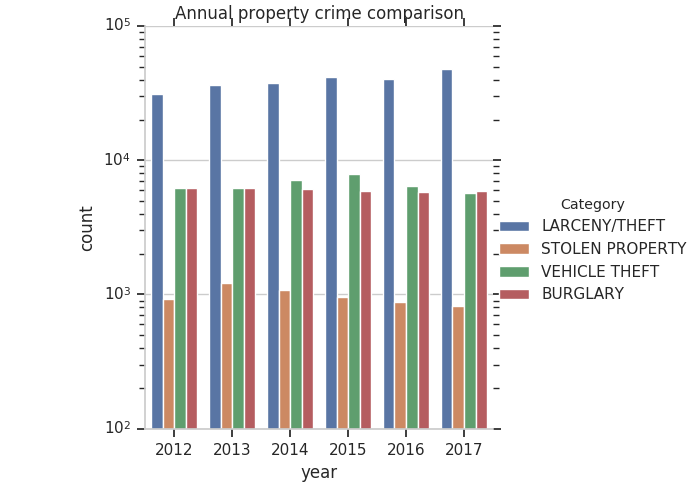

In [29]:
v = get_annual_property_crimes([2012,2013,2014, 2015, 2016, 2017])
v.sort_values(by=['year', 'Category'])
fig,ax=plt.subplots()
sb.catplot(x='year', y='count', hue='Category', data=v, kind='bar')
plt.title('Annual property crime comparison')
plt.yscale('log')
display(plt.show())

### Spatial Analysis (kmeans clustering)

In [31]:
area_dict = {}
area_dict['MISSION'] = [-122.4148,37.7599]
area_dict['BAYVIEW'] = [-122.3844,37.7304]
area_dict['CENTRAL'] = [-122.4075,37.7880]
area_dict['SOUTHERN'] = [-122.3940,37.7815]
area_dict['NORTHERN'] = [-122.4061,37.8002]
area_coordinate = pd.DataFrame(area_dict).transpose()
area_coordinate.columns = ['X','Y']

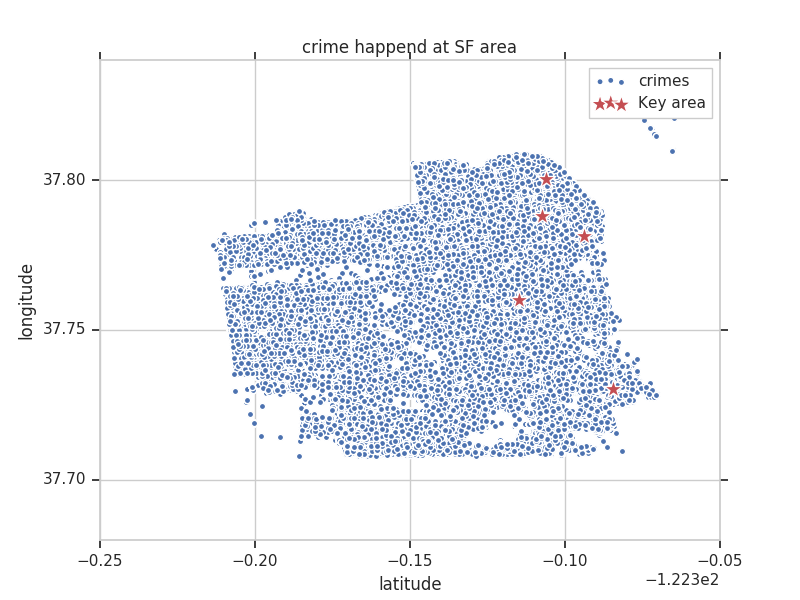

In [32]:
visual = sf_data.select('X','Y')
visual = visual.select(*(visual[c].cast("float").alias(c) for c in visual.columns))
#sampling_rate = 0.15
#visual = visual.sample(False,sampling_rate,seed=6)   #sampling data
visual_pandas = visual.toPandas()
fig,ax =plt.subplots()
ax.scatter(visual_pandas['X'],visual_pandas['Y'],label ='crimes')
ax.scatter(area_coordinate['X'],area_coordinate['Y'],c='r', marker = '*',s=200,label='Key area')
ax.set_xlabel('latitude')
ax.set_ylabel('longitude')
ax.set_title('crime happend at SF area')
ax.legend()
display(fig)

In [33]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import ClusteringEvaluator
vecAssembler = VectorAssembler(inputCols=["X","Y"], outputCol="features")
df_kmeans = vecAssembler.transform(visual)
cost = np.zeros(25)
for k in range(2,25):
  kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol('features')
  model = kmeans.fit(df_kmeans.sample(False,0.01))
  cost[k] = model.computeCost(df_kmeans)

fig,ax = plt.subplots()
ax.plot(range(2,25),cost[2:25])
ax.set_title('cost vs k')
ax.set_xlabel('K')
ax.set_ylabel('cost score')
display(fig)

In [34]:
# i choose k=15 as a choice between performance and computation complexity
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import ClusteringEvaluator
n=15
kmeans = KMeans().setK(n).setSeed(1).setFeaturesCol('features')
model = kmeans.fit(df_kmeans.sample(False,0.01))
result = model.transform(df_kmeans)
result = result.toPandas()
display(result)
centers = model.clusterCenters()
centers = pd.DataFrame(centers,columns=['center_x','center_y'])

X,Y,features,prediction
-122.42158508300781,37.76169967651367,"List(1, 2, List(), List(-122.42158508300781, 37.76169967651367))",4
-122.4144058227539,37.7841911315918,"List(1, 2, List(), List(-122.4144058227539, 37.7841911315918))",5
-122.4144058227539,37.7841911315918,"List(1, 2, List(), List(-122.4144058227539, 37.7841911315918))",5
-122.4144058227539,37.7841911315918,"List(1, 2, List(), List(-122.4144058227539, 37.7841911315918))",5
-122.43112182617188,37.80046844482422,"List(1, 2, List(), List(-122.43112182617188, 37.80046844482422))",12
-122.4517822265625,37.787086486816406,"List(1, 2, List(), List(-122.4517822265625, 37.787086486816406))",13
-122.37401580810547,37.72920227050781,"List(1, 2, List(), List(-122.37401580810547, 37.72920227050781))",11
-122.37401580810547,37.72920227050781,"List(1, 2, List(), List(-122.37401580810547, 37.72920227050781))",11
-122.40657043457031,37.78780746459961,"List(1, 2, List(), List(-122.40657043457031, 37.78780746459961))",5
-122.41729736328125,37.786258697509766,"List(1, 2, List(), List(-122.41729736328125, 37.786258697509766))",5


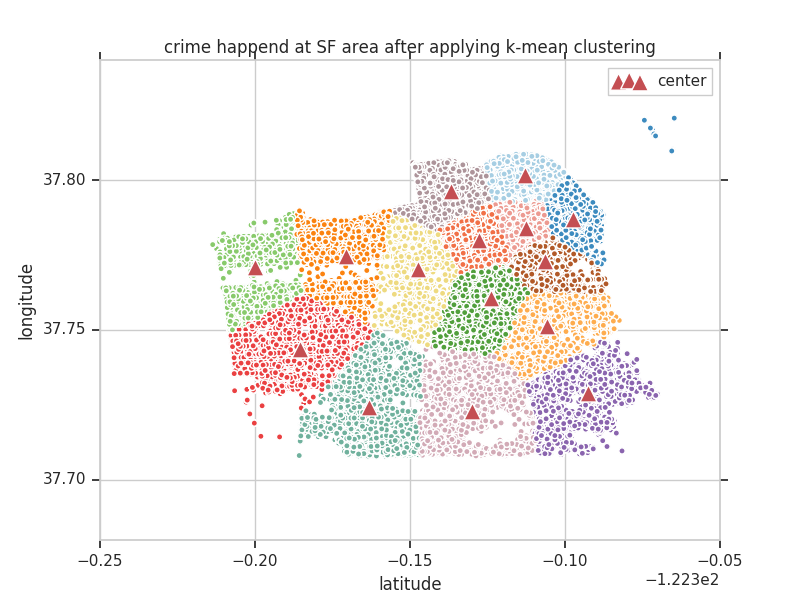

In [35]:
fig2,ax2 = plt.subplots()
plt.scatter(result['X'], result['Y'], c=result['prediction'], cmap=plt.cm.Paired,label=None)
ax2.scatter(centers['center_x'],centers['center_y'],c='r',marker = '^',s=150,label='center')
ax2.set_xlabel('latitude')
ax2.set_ylabel('longitude')
ax2.set_title('crime happend at SF area after applying k-mean clustering')
ax2.legend()
display(fig2)